In [1]:
] activate .

  Activating project at `/media/dasc3/SAMSUNG_SSD/dasc3/devansh/gatekeeper-exp-xavier/colcon_ws/src/process_bagfiles/julia_proc`


In [2]:
] st

Status `/media/dasc3/SAMSUNG_SSD/dasc3/devansh/gatekeeper-exp-xavier/colcon_ws/src/process_bagfiles/julia_proc/Project.toml`
  [682c06a0] JSON v0.21.4
  [b8a86587] NearestNeighbors v0.4.16
  [f0f68f2c] PlotlyJS v0.18.12
  [91a5bcdd] Plots v1.39.0
  [6038ab10] Rotations v1.6.1
  [90137ffa] StaticArrays v1.9.1


In [3]:
using StaticArrays, Plots, LinearAlgebra
using Rotations

In [4]:
gr()

Plots.GRBackend()

In [211]:
module Mapper

using JSON
using Rotations, StaticArrays
using Plots
using LinearAlgebra
using NearestNeighbors

struct TF{F}
    quat::Rotations.QuatRotation{F}
    tran::SVector{3, F}
end

function homogeneous(tf::TF)
    return [
        [RotMatrix3(tf.quat);; tf.tran];
        [zeros(1, 3);; ones(1,1)]
    ]
end

nisnan(v) = !isnan(v)

struct SliceMap{F}
    clean::Bool
    certified::Bool
    timestamp::F
    tf_true::TF{F}
    tf_noisy::TF{F}
    xs::Vector{F}
    ys::Vector{F}
    ds::Vector{F}
    resolution::F
end



function SliceMap(clean::Bool,
    certified::Bool,
    timestamp::F,
    resolution::F,
    data::Matrix{F},
    tf_true::TF{F},
    tf_noisy::TF{F},
    origin_x::F,
    origin_y::F) where {F}
    
    # get the axes for the data
    h, w = size(data)
    xs = origin_x .+ resolution * (0:(w-1))
    ys = origin_y .+ resolution * (0:(h-1))

    xx = [xx for yy in ys, xx in xs] |> vec

    yy = [yy for yy in ys, xx in xs] |> vec

    dd = vec(data)

    inds = nisnan.(dd)
    
    return SliceMap{F}(clean, certified, timestamp, tf_true, tf_noisy, xx[inds], yy[inds], dd[inds], resolution)
    
end

struct SliceSet{M1,M2,M3}
    ground_truth::M1
    uncertified::M2
    certified::M3
end

function reinterpolate(slice::SliceMap{F}, xrange, yrange; frame=:world) where {F}
    
    pos = Array(hcat(slice.xs, slice.ys, ones(length(slice.xs)), ones(length(slice.xs)))' )
    
    # rotation matrix
    if frame==:world
        H = 1.0 * I(4)
    elseif frame==:true
        H = homogeneous(slice.tf_true)
    elseif frame==:noisy
        H = homogeneous(slice.tf_noisy)
    else
        error()
    end
    
    new_pos = inv(H) * pos
    
    return reinterpolate(new_pos[1:2, :], slice.ds, xrange, yrange, slice.resolution)
        
end

function reinterpolate(new_pos::Matrix{F}, ds, xrange, yrange, resolution)  where {F}
    
    tree = KDTree(new_pos)
    
    res = zeros(length(xrange), length(yrange))
    
    for i in 1:length(xrange)
        for j in 1:length(yrange)
            
            ind , d = nn(tree,@SVector [xrange[i], yrange[j]] )
            if d <= resolution
                res[i, j] = ds[ind]
            else
                res[i, j] = NaN
            end
        end
    end
    
    return res
    
end

struct ReinterpolatedSliceMap{F, L, R}
    clean::Bool
    certified::Bool
    timestamp::F
    resolution::F
    frame::L
    xrange::R
    yrange::R
    ds::Matrix{F}
end

function ReinterpolatedSliceMap(slice::SliceMap{F}, xrange, yrange; frame=:world) where {F}
    
    res = reinterpolate(slice, xrange, yrange; frame=frame)
    
    return ReinterpolatedSliceMap(
    slice.clean, 
    slice.certified, 
    slice.timestamp, 
    slice.resolution,
    frame, 
    xrange, 
    yrange, 
    res)
    
    
end

# function basic_plot!(slice::SliceMap; kwargs...)

#     xs, ys = get_axes(slice)
    
#     heatmap!(xs, ys, slice.data; aspect_ratio=:equal, kwargs...)
# end


function splot!(slice::SliceMap; frame=:world, color_grading=nothing, kwargs...)
    
    # get the world coordinates
#     xx, yy, dd = Mapper.unpivot(slice)
    xx = slice.xs
    yy = slice.ys
    if isnothing(color_grading)
        dd = slice.ds
    else
        dd = color_grading.(slice.ds)
    end
    
    # transform the frame now
    zz = ones(length(xx))
    pos = hcat(xx, yy, zz, ones(length(xx)))'
    
    # rotation matrix
    if frame==:world
        H = 1.0 * I(4)
    elseif frame==:true
        H = homogeneous(slice.tf_true)
    elseif frame==:noisy
        H = homogeneous(slice.tf_noisy)
    else
        error()
    end
    
    new_pos = H * pos
    
    # get the xy components
    new_xx = new_pos[1, :]
    new_yy = new_pos[2, :]
    # ignore z component
    
    # plot
    scatter!(new_xx, new_yy, marker_z=dd; markerstrokewidth=0, aspect_ratio=:equal, kwargs...)
    
end

function splot(slice::SliceMap; kwargs...)
    p1 = plot()
    splot!(slice; kwargs...)
    return p1
end

function splot(slice::ReinterpolatedSliceMap; kwargs...)
    p1 = plot()
    splot!(slice; kwargs...)
    return p1
end

function splot(sliceSet::SliceSet; kwargs...)
    
    l = @layout [a b c]
    
    pp = plot(
        splot(sliceSet.ground_truth; kwargs...),
        splot(sliceSet.uncertified; kwargs...),
        splot(sliceSet.certified; kwargs...);
    layout=l, size=(1200, 400)
    )
    
    return pp
end


function splot!(remap::ReinterpolatedSliceMap; color_grading=nothing, kwargs...)
    
    if isnothing(color_grading)
        ds = remap.ds
    else
        ds = color_grading.(remap.ds)
    end
    
    heatmap!(remap.xrange, remap.yrange, ds'; kwargs...)
end

function load_slice(filename, clean, certified)
    
    o = JSON.parsefile(filename)
    data = 1.0 * stack(o["data"], dims=1)
    
    tf_true = TF(
        QuatRotation([o["tf_true"][v] for v in ["qw", "qx", "qy", "qz"]]...),
        @SVector [o["tf_true"][v] for v in ["x", "y","z"]]
    )
    
    tf_noisy = TF(
        QuatRotation([o["tf_noisy"][v] for v in ["qw", "qx", "qy", "qz"]]...),
        @SVector [o["tf_noisy"][v] for v in ["x", "y","z"]]
    )
    
    return SliceMap(
        clean,
        certified,
        o["timestamp"], 
        o["resolution"],
        data, 
        tf_true,
        tf_noisy,
        o["origin_x"],
        o["origin_y"]
    )
end

function freespace(map::ReinterpolatedSliceMap; d=2*map.resolution)
    
    isFree(v) = isnan(v) ? NaN : (v > d ? true : false)
    
    c = isFree.(map.ds)
    
    return c
    
end


end




Main.Mapper

In [212]:
xrange = -8:0.05:8
yrange = -8:0.1:8

-8.0:0.1:8.0

In [213]:
yrange

-8.0:0.1:8.0

In [214]:
data = zeros(length(xrange), length(yrange))
for i in 1:length(xrange )
    for j in 1:length(yrange) 
        data[i, j] = xrange[i]
    end
end

In [215]:
slice = Mapper.ReinterpolatedSliceMap(
true,  
    true,
    0.0,
    0.05,
    "world", 
    xrange, 
    yrange, 
    data)

Main.Mapper.ReinterpolatedSliceMap{Float64, String, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}(true, true, 0.0, 0.05, "world", -8.0:0.05:8.0, -8.0:0.1:8.0, [-8.0 -8.0 … -8.0 -8.0; -7.95 -7.95 … -7.95 -7.95; … ; 7.95 7.95 … 7.95 7.95; 8.0 8.0 … 8.0 8.0])

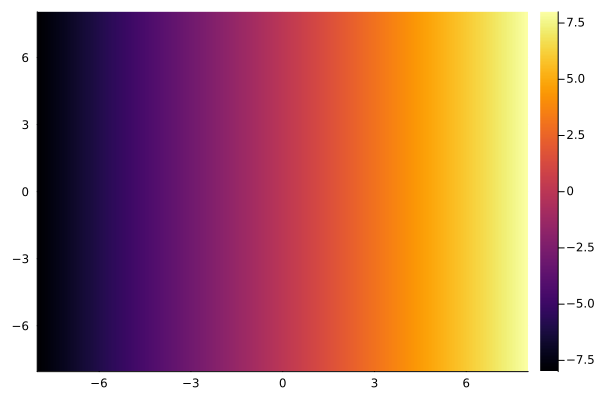

In [216]:
plot()
Mapper.splot!(slice)

In [217]:
# load one slice for testing
fn = "../noisy_slices_json/certified_00000.json"
slice = Mapper.load_slice(fn, false, true)
# load one slice for testing
fn = "../clean_slices_json/certified_02347.json"
slice_last = Mapper.load_slice(fn, true, true)

Main.Mapper.SliceMap{Float64}(true, true, 1.7049067371572647e9, Main.Mapper.TF{Float64}([-0.49151138705690023 0.8708157491613526 0.009822800311236245; -0.8708553231292187 -0.4915391862851952 0.00048427635968725097; 0.005250006752989212 -0.008316210593806682 0.9999516378657787], [-0.07953503825032436, 1.4318054344421582, 1.109388327101338]), Main.Mapper.TF{Float64}([-0.4914862392578109 0.8708311389815578 0.009716172100990607; -0.8708708947795291 -0.49151175811304115 0.00027615671111918313; 0.005016098694768094 -0.008325804268027818 0.9999527587527194], [-0.07954144460611971, 1.431791176896825, 1.109386212883566]), [-9.07500071823597, -9.000000715255737, -9.000000715255737, -8.925000712275505, -8.925000712275505, -8.925000712275505, -8.850000709295273, -8.850000709295273, -8.77500070631504, -8.77500070631504  …  8.249999970197678, 8.249999970197678, 8.249999970197678, 8.249999970197678, 8.32499997317791, 8.32499997317791, 8.32499997317791, 8.32499997317791, 8.32499997317791, 8.3999999761

In [218]:
xrange = -8:0.1:8
yrange = -8:0.1:8

-8.0:0.1:8.0

In [239]:
# function load_all()
    
#     clean_dir = "../clean_slices_json/"
#     noisy_dir = "../noisy_slices_json/"
    
#     clean_uncert_fs = [clean_dir * f for f in readdir(clean_dir) if occursin("uncertified", f)]
#     noisy_uncert_fs = [noisy_dir * f for f in readdir(noisy_dir) if occursin("uncertified", f)]
#     noisy_cert_fs = [noisy_dir * f for f in readdir(noisy_dir) if !occursin("uncertified", f)]
    

#     slices = Mapper.SliceSet[]
#     for i=1:5:length(clean_uncert_fs)
        
#         slice = Mapper.SliceSet(
#             Mapper.load_slice(clean_uncert_fs[i], true, false), 
#             Mapper.load_slice(noisy_uncert_fs[i], false, false), 
#             Mapper.load_slice(noisy_cert_fs[i], false, true), 
#         )
#         push!(slices, slice)
#         @show i, length(clean_uncert_fs)
        
#     end
    
#     return slices
    
# end

# # function load_all_reinterpolate(slices, xrange, yrange; frame=:world)
    
# #     return [Mapper.SliceSet(
# #             Mapper.ReinterpolatedSliceMap(s.ground_truth, xrange, yrange; frame=frame), 
# #         Mapper.ReinterpolatedSliceMap(s.uncertified, xrange, yrange; frame=frame), 
# #         Mapper.ReinterpolatedSliceMap(s.certified, xrange, yrange; frame=frame)
# #         ) for s in slices]
# # end

# function load_all_reinterpolate(slices, xrange, yrange)
    
#     return [Mapper.SliceSet(
#             Mapper.ReinterpolatedSliceMap(s.ground_truth, xrange, yrange; frame=:true), 
#         Mapper.ReinterpolatedSliceMap(s.uncertified, xrange, yrange; frame=:true), 
#         Mapper.ReinterpolatedSliceMap(s.certified, xrange, yrange; frame=:true)
#         ) for s in slices]
# end
    

function load_all_reinterpolate(xrange = xrange, yrange = yrange)
    
    clean_dir = "../clean_slices_json/"
    noisy_dir = "../noisy_slices_json/"
    
    clean_uncert_fs = [clean_dir * f for f in readdir(clean_dir) if occursin("uncertified", f)]
    noisy_uncert_fs = [noisy_dir * f for f in readdir(noisy_dir) if occursin("uncertified", f)]
    noisy_cert_fs = [noisy_dir * f for f in readdir(noisy_dir) if !occursin("uncertified", f)]
    

    slices = Mapper.SliceSet[]
    for i=1:100:1000 #length(clean_uncert_fs)
        
        s1 = Mapper.load_slice(clean_uncert_fs[i], true, false)
        s2 = Mapper.load_slice(noisy_uncert_fs[i], false, false)
        s3 = Mapper.load_slice(noisy_cert_fs[i], false, true)
    
        
        r1 = Mapper.ReinterpolatedSliceMap(s1, xrange, yrange; frame=:true)
        r2 = Mapper.ReinterpolatedSliceMap(s2, xrange, yrange; frame=:true)
        r3 = Mapper.ReinterpolatedSliceMap(s3, xrange, yrange; frame=:true)
        
        slice = Mapper.SliceSet(r1, r2, r3)
        
        push!(slices, slice)
        @show i, length(clean_uncert_fs)
        
    end
    
    return slices
    
end

# function load_all_reinterpolate(slices, xrange, yrange; frame=:world)
    
#     return [Mapper.SliceSet(
#             Mapper.ReinterpolatedSliceMap(s.ground_truth, xrange, yrange; frame=frame), 
#         Mapper.ReinterpolatedSliceMap(s.uncertified, xrange, yrange; frame=frame), 
#         Mapper.ReinterpolatedSliceMap(s.certified, xrange, yrange; frame=frame)
#         ) for s in slices]
# end

# function load_all_reinterpolate(slices, xrange, yrange)
    
#     return [Mapper.SliceSet(
#             Mapper.ReinterpolatedSliceMap(s.ground_truth, xrange, yrange; frame=:true), 
#         Mapper.ReinterpolatedSliceMap(s.uncertified, xrange, yrange; frame=:true), 
#         Mapper.ReinterpolatedSliceMap(s.certified, xrange, yrange; frame=:true)
#         ) for s in slices]
# end

load_all_reinterpolate (generic function with 3 methods)

In [240]:
reinterpolated_slices = load_all_reinterpolate()

(i, length(clean_uncert_fs)) = (1, 2348)
(i, length(clean_uncert_fs)) = (101, 2348)
(i, length(clean_uncert_fs)) = (201, 2348)
(i, length(clean_uncert_fs)) = (301, 2348)
(i, length(clean_uncert_fs)) = (401, 2348)
(i, length(clean_uncert_fs)) = (501, 2348)
(i, length(clean_uncert_fs)) = (601, 2348)
(i, length(clean_uncert_fs)) = (701, 2348)
(i, length(clean_uncert_fs)) = (801, 2348)
(i, length(clean_uncert_fs)) = (901, 2348)


10-element Vector{Main.Mapper.SliceSet}:
 Main.Mapper.SliceSet{Main.Mapper.ReinterpolatedSliceMap{Float64, Bool, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, Main.Mapper.ReinterpolatedSliceMap{Float64, Bool, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, Main.Mapper.ReinterpolatedSliceMap{Float64, Bool, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}(Main.Mapper.ReinterpolatedSliceMap{Float64, Bool, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}(true, false, 1.7049062676375353e9, 0.07500000298023224, true, -8.0:0.1:8.0, -8.0:0.1:8.0, [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN]), Main.Mapper.ReinterpolatedSliceMap{Float64, Bool, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}(false, false, 1.7049062677406085e9, 0.07500000298023224, true

In [241]:
# reinterpolated_slices = load_all_reinterpolate(slices, xrange, yrange)

In [242]:
obstacle_grading(v) = isnan(v) ? NaN : (v > 0.15 ? 1.0 : 0.0) 

obstacle_grading (generic function with 1 method)

In [243]:
# plot()
# Mapper.splot!(slice; color_grading = obstacle_grading);

In [244]:
# plot()
# Mapper.splot!(slice_last);

In [245]:
#slices[1].certified

In [246]:
# Mapper.splot(slices[end]);

In [247]:
# p1 = plot()
# Mapper.splot!(slices[end].ground_truth; frame=:noisy,  color_grading = obstacle_grading)
# p2 = plot()
# Mapper.splot!(slices[end].certified; frame=:noisy,  color_grading = obstacle_grading)

# plot(p1, p2, layout=(@layout [a b]), size=(800, 400), link=:all);

In [248]:
function plot_fov!()
    
    yaw = π/2
    fov=π/2
    L = 5.0
    
    
    x0, y0 = 0, 0
    x1, y1 = x0 + L * cos(yaw + fov/2), y0 + L * sin(yaw + fov/2)
    x2 , y2 = x0 + L * cos(yaw - fov/2), y0 + L * sin(yaw - fov/2)
    
    plot!([x0, x1, x2, x0], [y0, y1, y2, y0])
end

plot_fov! (generic function with 1 method)

In [249]:
gr()

Plots.GRBackend()

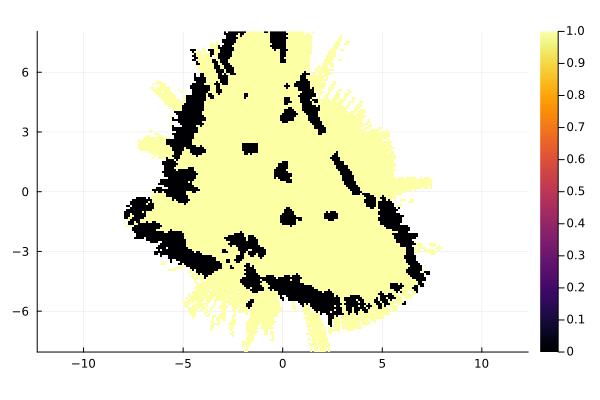

In [250]:
plot()
Mapper.splot!(reinterpolated_slices[end].ground_truth; color_grading=obstacle_grading, aspect_ratio=:equal)

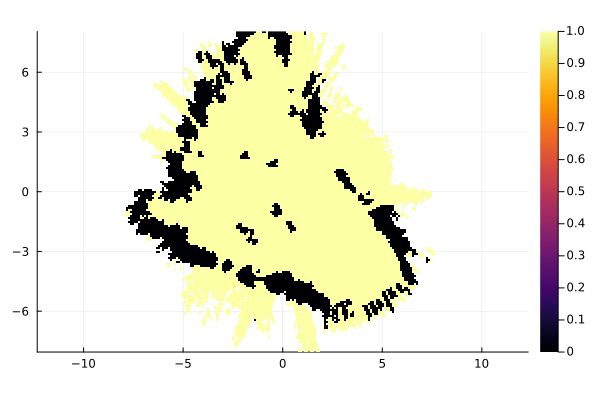

In [251]:
plot()
Mapper.splot!(reinterpolated_slices[end].uncertified; color_grading=obstacle_grading, aspect_ratio=:equal)

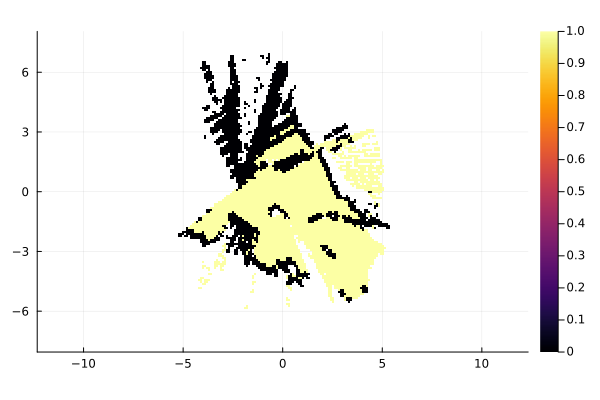

In [252]:
plot()
Mapper.splot!(reinterpolated_slices[end].certified; color_grading=obstacle_grading, aspect_ratio=:equal)

In [253]:
obst_gthr = 1 .- obstacle_grading.(reinterpolated_slices[end].ground_truth.ds)
free_uncertified = obstacle_grading.(reinterpolated_slices[end].uncertified.ds)
free_certified = obstacle_grading.(reinterpolated_slices[end].certified.ds)

161×161 Matrix{Float64}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [254]:
plotlyjs()

Plots.PlotlyJSBackend()

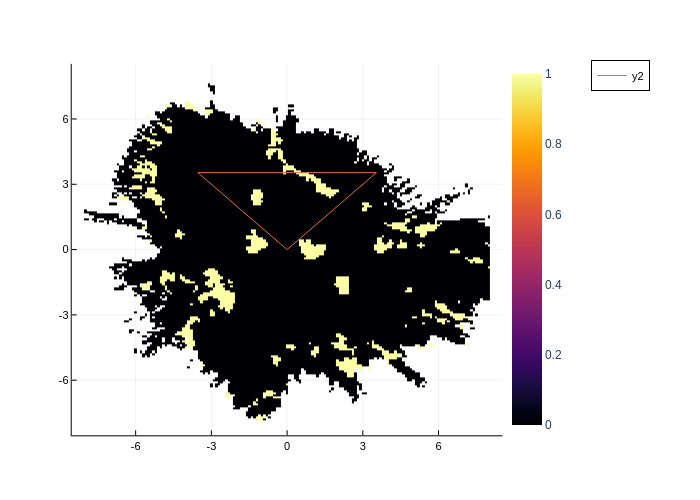

In [255]:
heatmap(xrange, yrange, obst_gthr .* free_uncertified)
plot_fov!()

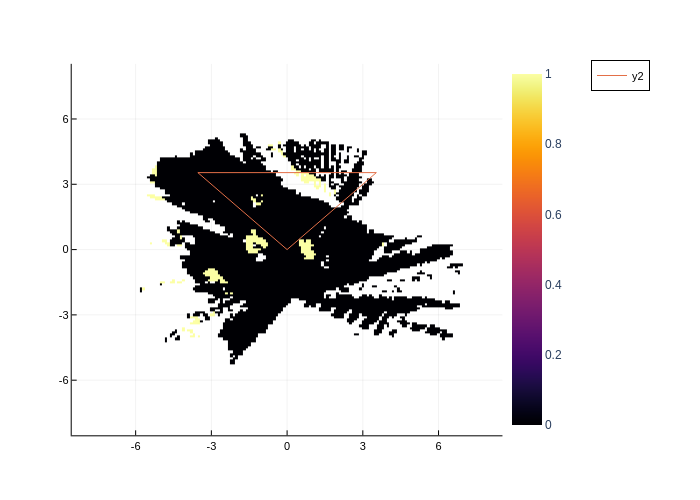

In [256]:
heatmap(xrange, yrange, obst_gthr .* free_certified)
plot_fov!()

In [257]:
# anim = @animate for i=1:20:length(reinterpolated_slices)
#     Mapper.splot(reinterpolated_slices[i]; color_grading=obstacle_grading, aspect_ratio=:equal, colorbar = false)
# end

In [258]:
# gif(anim, "anim.gif", fps = 3)